<a href="https://colab.research.google.com/github/PUC-RecSys-Class/RecSysPUC-2020/blob/master/practicos/GRU4Rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Gated Recurrent Units for session-based next item prediction

Patricio Cerda, Bastián Mavrakis, Denis Parra

### Ambiente: Python3 + GPU

## Descargar datos y repositorio

In [1]:
# Clone repo
!git clone https://github.com/pcerdam/KerasGRU4Rec --single-branch src

Cloning into 'src'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 198 (delta 11), reused 24 (delta 9), pack-reused 161
Receiving objects: 100% (198/198), 10.58 MiB | 19.66 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [2]:
# Download RecSys Challenge 2015 dataset
!rm -r sample_data
!curl https://s3-eu-west-1.amazonaws.com/yc-rdata/yoochoose-data.7z --output data.7z

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  273M  100  273M    0     0  18.8M      0  0:00:14  0:00:14 --:--:-- 21.8M


In [3]:
# Extract dataset
!7z e data.7z -o./rsc15
!rm data.7z
!mkdir data


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 287211932 bytes (274 MiB)

Extracting archive: data.7z
--
Path = data.7z
Type = 7z
Physical Size = 287211932
Headers Size = 255
Method = LZMA:24
Solid = +
Blocks = 2

  0%      0% - yoochoose-buys.dat                           1% - yoochoose-buys.dat                           2% - yoochoose-buys.dat                           3% 1 - yoochoose-clicks.dat                               4% 1 - yoochoose-clicks.dat                               5% 1 - y

# Preprocesar dataset

In [4]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
src_path = './rsc15/'
dst_path   = './data/'

In [6]:
def process(src_path, dst_path):
  data = pd.read_csv(src_path + 'yoochoose-clicks.dat', sep=',', header=None, usecols=[0,1,2], dtype={0:np.int32, 1:str, 2:np.int64})
  data.columns = ['SessionId', 'TimeStr', 'ItemId']

  # Add timestamp
  data['Time'] = data.TimeStr.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp())
  del(data['TimeStr'])

  # Filter by session size > 1
  session_lengths = data.groupby('SessionId').size()  
  data = data[np.in1d(data.SessionId, session_lengths[session_lengths>1].index)]
  
  # Filter by "known" (appears >= 5) items
  item_supports = data.groupby('ItemId').size()
  data = data[np.in1d(data.ItemId, item_supports[item_supports>=5].index)]
  
  # Filter by session size > 2
  session_lengths = data.groupby('SessionId').size()
  data = data[np.in1d(data.SessionId, session_lengths[session_lengths>=2].index)]

  # Test split is entire last day
  tmax = data.Time.max()
  session_max_times = data.groupby('SessionId').Time.max()
  
  session_train = session_max_times[session_max_times < tmax-86400].index
  train = data[np.in1d(data.SessionId, session_train)]
  
  session_test = session_max_times[session_max_times >= tmax-86400].index
  test = data[np.in1d(data.SessionId, session_test)]
  test = test[np.in1d(test.ItemId, train.ItemId)]
  tslength = test.groupby('SessionId').size()
  test = test[np.in1d(test.SessionId, tslength[tslength>=2].index)]
  print('Test set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(test), test.SessionId.nunique(), test.ItemId.nunique()))
  test.to_csv(dst_path + 'test.tsv', sep='\t', index=False)

  # Validation: second to last day. Train: remainder
  tmax = train.Time.max()
  session_max_times = train.groupby('SessionId').Time.max()
  session_train = session_max_times[session_max_times < tmax-86400].index
  session_valid = session_max_times[session_max_times >= tmax-86400].index

  train_tr = train[np.in1d(train.SessionId, session_train)]
  valid = train[np.in1d(train.SessionId, session_valid)]
  valid = valid[np.in1d(valid.ItemId, train_tr.ItemId)]
  tslength = valid.groupby('SessionId').size()
  valid = valid[np.in1d(valid.SessionId, tslength[tslength>=2].index)]
  print('Validation set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(valid), valid.SessionId.nunique(), valid.ItemId.nunique()))
  valid.to_csv(dst_path + 'validation.tsv', sep='\t', index=False)
  
  
  print('Train set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(train_tr), train_tr.SessionId.nunique(), train_tr.ItemId.nunique()))
  train_tr.to_csv(dst_path + 'train.tsv', sep='\t', index=False)


In [7]:
process(src_path, dst_path)  # Takes ~10 minutes

Test set
	Events: 71222
	Sessions: 15324
	Items: 6751
Validation set
	Events: 58233
	Sessions: 12372
	Items: 6359
Train set
	Events: 31579006
	Sessions: 7953885
	Items: 37483


In [8]:
def train_fraction(df, fraction, prefix="train", path="./data/"):
    
    length = len(df['ItemId'])
    first_session = df.iloc[length - length//fraction].SessionId
    df = df.loc[df['SessionId'] >= first_session]
    itemids = df['ItemId'].unique()
    n_items = len(itemids)

    print('Fractioned data set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(df), df.SessionId.nunique(), df.ItemId.nunique()))
    filename = path + '{}_{}.tsv'.format(prefix, fraction)
    df.to_csv(filename, sep='\t', index=False)
    print("Saved as {}".format(filename))

In [9]:
# Obtain most recent 1/nth fraction of train for demo purposes
fraction = 64
train = pd.read_csv(dst_path + 'train.tsv', sep='\t', dtype={'ItemId':np.int64})
train_fraction(train, fraction)


Fractioned data set
	Events: 71391
	Sessions: 17450
	Items: 8724
Saved as ./data/train_64.tsv


# Entrenamiento

In [10]:
!python src/model/gru4rec.py --epochs 200 --train-path ./data/train_64.tsv --dev-path ./data/validation.tsv --test-path ./data/test.tsv

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(512, 1, 8725)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 100), (512, 100)]  2648100   
_________________________________________________________________
dropout (Dropout)            (512, 100)                0         
_________________________________________________________________
dense (Dense)                (512, 8725)               881225    
Total params: 3,529,325
Trainable params: 3,529,325
Non-trainable params: 0
_________________________________________________________________
Epoch 1. Loss: 8.35590:  97% 16929/17451 [00:12<00:00, 1326.04it/s]
Epoch 2. Loss: 7.89026:  97% 16929/17451 [00:05<00:00, 3191.77it/s]
Epoch 3. Loss: 7.63149:  97% 16929/17451 [00:05<00:00, 3168.15it/s]
Epoch 4. Loss: 7.40393:  97% 16929/174

## Resultados

Luego de 200 épocas, deberías obtener un desempeño similar al siguiente:

	 - Recall@20: 0.47
	 - MRR@20   : 0.16


Para replicar resultados del paper, utiliza el set de entrenamiento completo

## Aprovechando información implícita: Dwell Time

Podemos utilizar el tiempo que cada item fue visitado por cada usuario para realizar mejores recomendaciones.

El supuesto es: a mayor tiempo de permanencia (dwell time) en un item, más interesado está el usuario en dicho item.

Se hará item boosting en el set de entrenamiento.

In [11]:
def preprocess_df(df):    
    n_items = len(df['ItemId'].unique())
    aux = list(df['ItemId'].unique())
    itemids = np.array(aux)
    itemidmap = pd.Series(data=np.arange(n_items), index=itemids)  # (id_item => (0, n_items))
    
    item_key = 'ItemId'
    session_key = 'SessionId'
    time_key = 'Time'
    
    data = pd.merge(df, pd.DataFrame({item_key:itemids, 'ItemIdx':itemidmap[itemids].values}), on=item_key, how='inner')
    data.sort_values([session_key, time_key], inplace=True)

    length = len(data['ItemId'])
        
    return data

In [12]:
def compute_dwell_time(df):
    times_t = np.roll(df['Time'], -1) # Take time row
    times_dt  = df['Time']            # Copy, then displace by one
    diffs = np.subtract(times_t, times_dt) # Take pairwise difference
    length = len(df['ItemId'])
    
    # cummulative offset start for each session
    offset_sessions = np.zeros(df['SessionId'].nunique()+1, dtype=np.int32)
    offset_sessions[1:] = df.groupby('SessionId').size().cumsum() 
    offset_sessions = offset_sessions - 1
    offset_sessions = np.roll(offset_sessions, -1)
    
    np.put(diffs.values, offset_sessions, np.zeros((offset_sessions.shape)), mode='raise')

    return diffs

In [13]:
def get_distribution(dts):
    filtered = np.array(list(filter(lambda x: int(x) != 0, dts)))
    pd_dts = pd.DataFrame(filtered)
    pd_dts.boxplot(vert=False, showfliers=False)
    plt.xlabel("Seconds")
    plt.yticks([])
    plt.title("Dwell time distribution for RSC15 dataset")
    plt.show()
    pd_dts.describe()

In [14]:
def join_dwell_reps(df, dt, threshold=2000):
    # Calculate d_ti/threshold + 1 then add column to dataFrame
    dt //= threshold
    dt += 1   
    df['DwellReps'] = pd.Series(dt.astype(np.int64), index=dt.index)

In [15]:
def augment(df):    
    col_names = list(df.columns.values)[:3]
    augmented = np.repeat(df.values, df['DwellReps'], axis=0) 
    augmented = pd.DataFrame(data=augmented[:,:3],
                             columns=col_names)
    dtype = {'SessionId': np.int64, 
             'ItemId': np.int64, 
             'Time': np.float32}
    
    for k, v in dtype.items():
        augmented[k] = augmented[k].astype(v)                  
    
    return augmented

In [16]:
new_df = preprocess_df(train)
dts = compute_dwell_time(new_df)

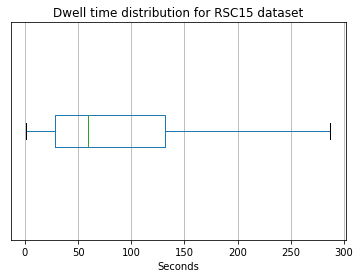

In [17]:
# Visualize
get_distribution(dts)

In [18]:
# threshold is a hyperparameter
join_dwell_reps(new_df, dts, threshold=75)

# augment the sessions copying each entry an additional (dwellReps[i]-1) times
df_aug = augment(new_df)
df_aug.to_csv("./data/augmented_train.csv", index=False, sep='\t')

In [19]:
# retrieve 1/n most recent fraction for demo purposes 
# (note it is a smaller fraction due to the inflation process)
fraction = 64*7
train_fraction(df_aug, fraction, prefix='aug_train')

Fractioned data set
	Events: 151923
	Sessions: 16351
	Items: 8484
Saved as ./data/aug_train_448.tsv


## Entrenamiento con Dwell Time

In [20]:
!python src/model/gru4rec.py --epochs 200 --train-path ./data/aug_train_448.tsv --dev-path ./data/validation.tsv --test-path ./data/test.tsv

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(512, 1, 8485)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 100), (512, 100)]  2576100   
_________________________________________________________________
dropout (Dropout)            (512, 100)                0         
_________________________________________________________________
dense (Dense)                (512, 8485)               856985    
Total params: 3,433,085
Trainable params: 3,433,085
Non-trainable params: 0
_________________________________________________________________
Epoch 1. Loss: 7.63209:  97% 15835/16352 [00:20<00:00, 772.91it/s] 
Epoch 2. Loss: 6.85688:  97% 15835/16352 [00:13<00:00, 1217.16it/s]
Epoch 3. Loss: 5.91601:  97% 15835/16352 [00:13<00:00, 1214.67it/s]
Epoch 4. Loss: 5.05054:  97% 15835/163

Indique el resultado del modelo con Dwell Time. 

**COMPLETE**

La información implícita que provee esta técnica sí está siendo útil para
que el modelo aprenda de mejor manera. Luego del desarrollo de las simulaciones, se obtiene mejores resultados tanto en Recall@20 y MRR@20. Estos
resultados son considerablemente mejores.